In [149]:
import pandas as pd
import requests
from io import BytesIO
from typing import List

def load_and_merge_csv_xz_from_github(years: List[int], companies: List[str], base_url: str) -> pd.DataFrame:
    all_dataframes = []
    
    for year in years:
        for company in companies:
            filename = f"df_{year}_{company}.csv.xz"
            file_url = f"{base_url}/{filename}"
            
            response = requests.get(file_url)
            if response.status_code == 200:
                file_content = BytesIO(response.content)
                df = pd.read_csv(file_content, compression='xz')
                all_dataframes.append(df)

    merged_dataframe = pd.concat(all_dataframes, ignore_index=True)

    # Sort dataframe by date
    df_sorted = merged_dataframe.sort_values(by='post_date')

    # Remove the 'Unnamed: 0' column
    df_sorted = df_sorted.drop(columns=['Unnamed: 0'])
    
    # Drop 'year' columns that was used previously to split dataframes and save them as smaller csv files 
    df_sorted = df_sorted.drop(columns=['year'])


    # Reset the index of the dataframe and drop the old one
    df_sorted = df_sorted.reset_index(drop=True)

    return df_sorted

    
base_url = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data"
years = [2015, 2016, 2017, 2018, 2019]
companies = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'GOOG', 'MSFT']
tweets_df = load_and_merge_csv_xz_from_github(years, companies, base_url)



In [150]:
tweets_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,AAPL,apple,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
2,AMZN,Amazon.com,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,TSLA,Tesla Inc,550443808606126081,aaplstocknews,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [151]:
import pandas as pd
import re

def filter_tweets(df):
    df = df.copy()

    print("Initial dataset length:", len(df))

    # Normalize URLs in the tweet bodies - replace with "URL" or remove
    df['body'] = df['body'].apply(lambda text: re.sub(r'http\S+', 'URL', text))

    # Remove all duplicates based on 'tweet_id' and 'ticker_symbol' (seen as spam)
    df.drop_duplicates(subset=['tweet_id', 'ticker_symbol'], inplace=True, keep = False)
    print("After removing duplicate tweet_ids and ticker_symbols:", len(df))

    # Remove last duplicates based on 'tweet_id' and 'company_name'(will only apply to Google as they have different ticker_symbols)
    df.drop_duplicates(subset=['tweet_id', 'company_name'], inplace=True, keep = 'first')
    print("After removing duplicate tweet_ids and company_names (Google):", len(df))

    # Remove tweets with duplicate texts longer than 5 words considering the ticker symbol
    df['word_count'] = df['body'].apply(lambda text: len(text.split()))
    duplicates = df[(df['word_count'] > 5)].duplicated(subset=['body', 'ticker_symbol'], keep=False)
    df = df.loc[~df.index.isin(duplicates[duplicates].index)]
    print("After removing long duplicate texts:", len(df))

    # Apply counting functions
    df['hashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('#')))
    df['cashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('$')))
    df['mention_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('@')))

    # Filter tweets based on hashtag and cashtag counts
    df = df[(df['cashtag_count'] < 5) & (df['hashtag_count'] < 8)]
    print("After filtering by cashtags and hashtags:", len(df))

    # Ratio filters (cashtags, hashtags, mentions to words)
    df['cashtag_ratio'] = df['cashtag_count'] / df['word_count'].replace(0, 1)
    df['hashtag_ratio'] = df['hashtag_count'] / df['word_count'].replace(0, 1)
    df['mention_ratio'] = df['mention_count'] / df['word_count'].replace(0, 1)
    df = df[(df['cashtag_ratio'] <= 0.5) & (df['hashtag_ratio'] <= 0.5) & (df['mention_ratio'] <= 0.5)]
    print("After filtering by ratios:", len(df))

    # Keyword filter (defined by Wilksch, Abramova (2023) PyFin-sentiment: Towards a machine-learning-based model for deriving sentiment from financial tweets)
    keywords = ['bitcoin', 'etherium', 'btc', 'eth', 'nft', 'token', 'wallet', 'web3',
                'airdrop', 'wagmi', 'solana', 'opensea', 'cryptopunks', 'uniswap', 
                'lunar', 'hodl', 'binance', 'coinbase', 'cryptocom', 'doge']
    df['keyword_count'] = df['body'].apply(lambda text: sum(text.lower().count(kw) for kw in keywords))
    df = df[df['keyword_count'] <= 2]
    print("After filtering by keyword count:", len(df))

    df = df.reset_index(drop=True)

    return df


In [152]:
filtered_df = filter_tweets(tweets_df)


Initial dataset length: 4336445
After removing duplicate tweet_ids and ticker_symbols: 4336445
After removing duplicate tweet_ids and company_names (Google): 4288706
After removing long duplicate texts: 3196398
After filtering by cashtags and hashtags: 2529106
After filtering by ratios: 2508943
After filtering by keyword count: 2508222


In [153]:
import pandas as pd

def check_empty_bodies(df):
    # Check for empty or NaN entries in the 'body' column
    empty_bodies = df['body'].isna() | (df['body'] == '')
    
    # Count the number of empty or NaN entries
    empty_count = empty_bodies.sum()
    
    # Print the results
    if empty_count > 0:
        print(f"There are {empty_count} empty 'body' cells in the DataFrame.")
    else:
        print("There are no empty 'body' cells in the DataFrame.")

    # Optionally, you might want to return a DataFrame with the empty entries for review
    empty_entries = df[empty_bodies]
    return empty_entries


In [154]:
# Check processed data frame for missing text values
empty_entries = check_empty_bodies(filtered_df)
if not empty_entries.empty:
    print("Empty entries found:", empty_entries)

There are no empty 'body' cells in the DataFrame.


In [160]:
# check if data set contains emojis

# pip install emoji
import emoji

def contains_emoji(text):
    return emoji.emoji_count(text) > 0


filtered_df['has_emoji'] = filtered_df['body'].apply(contains_emoji)

any_emojis = filtered_df['has_emoji'].any()
print("Is there at least one emoji in the text body column?", any_emojis)




Is there at least one emoji in the text body column? True


In [161]:
import re
import emoji

def preprocess_text_column(df):
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Escape regex special characters and join them to form a regex pattern
    punctuation_marks = [',', '.', '?', '!', '*', ':', ';', '”', 
                         '“', '"', "’", "’", "%", "&", "'", "(",
                         ")", "-", '``', "''"]
    escaped_punctuation = [re.escape(char) for char in punctuation_marks]
    punctuation_pattern = f"[{''.join(escaped_punctuation)}]"

    def transform_text(text):
        # Replace emojis with a space
        text = emoji.replace_emoji(text, replace=' ')
        
        # Convert to lowercase
        text = text.lower()

        # Replace newlines with spaces
        text = text.replace('\n', ' ')

        # Remove repeated characters more than twice
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        
        # Remove specific punctuation
        text = re.sub(punctuation_pattern, '', text)

        # Strip and replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text

    # Apply the transformation to the 'body' column
    df['body'] = df['body'].apply(transform_text)
    
    return df

# Example usage:
# import pandas as pd
# df = pd.DataFrame({'body': ['Long money game. ♟                            We hope Jackboys has some Tesla stocks since their adding hype to $TSLA brand.']})
# print(preprocess_text_column(df))


In [162]:
# Preprocess text column
preprocessed_df = preprocess_text_column(filtered_df)



In [163]:
preprocessed_df['has_emoji_pp'] = preprocessed_df['body'].apply(contains_emoji)

any_emojis_pp = preprocessed_df['has_emoji_pp'].any()
print("Is there at least one emoji in the text body column?", any_emojis_pp)

Is there at least one emoji in the text body column? False


In [164]:
preprocessed_df = preprocessed_df.drop(columns=['has_emoji', 'has_emoji_pp'])


In [165]:
preprocessed_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,0,1,1,0.083333,0.0,0.083333,1
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,0,1,0,0.066667,0.0,0.000000,0
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,0,1,0,0.090909,0.0,0.000000,0


In [166]:
import pandas as pd
from datetime import datetime
import pytz

# Define a function to convert Istanbul time to New York time and format it
def convert_to_new_york_time(istanbul_datetime):
    istanbul_timezone = pytz.timezone('Europe/Istanbul')
    new_york_timezone = pytz.timezone('America/New_York')
    
    # Make the datetime timezone-aware in Istanbul time
    # istanbul_datetime = istanbul_timezone.localize(istanbul_datetime, is_dst=None) # leads to error when time changes
    istanbul_datetime = istanbul_timezone.localize(istanbul_datetime, is_dst=False)

    
    # Convert from Istanbul time to New York time
    new_york_datetime = istanbul_datetime.astimezone(new_york_timezone)
    
    # Format New York datetime to a string without timezone information
    formatted_new_york_datetime = new_york_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    return formatted_new_york_datetime

# # Example DataFrame with 'post_date' column
# data = {'post_date': ['2022-01-01 06:00:00', '2022-01-02 13:00:00', '2022-01-03 14:00:00']}
# df = pd.DataFrame(data)

# # Convert 'post_date' column to datetime dtype
# df['post_date'] = pd.to_datetime(df['post_date'])

# # Apply the function to convert and format Istanbul time to New York time
# df['date_new_york'] = df['post_date'].apply(convert_to_new_york_time)

# # Print the DataFrame with the new column 'date_new_york'
# df

In [167]:
# Convert 'post_date' column to datetime dtype
preprocessed_df['post_date'] = pd.to_datetime(preprocessed_df['post_date'])

# Apply the function to convert and format Istanbul time to New York time
preprocessed_df['date_new_york'] = preprocessed_df['post_date'].apply(convert_to_new_york_time)

In [168]:
preprocessed_df

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,0,1,0,0.050000,0.000000,0.000000,0,2014-12-31 17:01:36
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,0,2,2,0.153846,0.000000,0.153846,0,2014-12-31 17:06:47
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,0,1,1,0.083333,0.000000,0.083333,1,2014-12-31 17:14:42
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,0,1,0,0.066667,0.000000,0.000000,0,2014-12-31 17:14:42
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,0,1,0,0.090909,0.000000,0.000000,0,2014-12-31 17:15:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508217,AAPL,apple,1212159275637886976,GMGRIFF_79,2019-12-31 23:51:06,$aapl yearly~ heck of a year jan 2 19~around 2...,0,0,1,28,0,1,0,0.035714,0.000000,0.000000,0,2019-12-31 15:51:06
2508218,TSLA,Tesla Inc,1212160015332728833,Commuternyc,2019-12-31 23:54:03,patiently waiting for the no twitter sitter tw...,0,0,5,10,0,2,0,0.200000,0.000000,0.000000,0,2019-12-31 15:54:03
2508219,AAPL,apple,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,i dont discriminate i own both $aapl and $msft,1,0,1,9,0,2,0,0.222222,0.000000,0.000000,0,2019-12-31 15:55:37
2508220,MSFT,Microsoft,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,i dont discriminate i own both $aapl and $msft,1,0,1,9,0,2,0,0.222222,0.000000,0.000000,0,2019-12-31 15:55:37


In [169]:
from pyfin_sentiment.model import SentimentModel
import numpy as np
import pandas as pd  # Ensure pandas is imported if not already

# Initialize the sentiment model
model = SentimentModel("small")

def apply_batch_sentiment(texts, batch_size=1000):
    # Initialize lists to store sentiment results and probabilities
    sentiments = []
    probabilities = []
    
    # Process texts in batches
    total_texts = len(texts)
    for i in range(0, total_texts, batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Get predictions and probabilities
        batch_predictions = model.predict(batch_texts)
        batch_probabilities = model.predict_proba(batch_texts)
        
        sentiments.extend(batch_predictions)
        probabilities.extend(batch_probabilities)
        
        # Print progress
        processed = min(i + batch_size, total_texts)
        print(f"Processed {processed}/{total_texts} texts")
    
    return sentiments, probabilities


/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression

In [264]:
# Apply sentiment analysis in batches to the 'body' column
sentiment_df = preprocessed_df.copy()

results = apply_batch_sentiment(sentiment_df['body'].tolist(), batch_size=1000)
sentiment_df['sentiment'] = results[0]
sentiment_df['sentiment_probability'] = results[1]

Processed 1000/2508222 texts
Processed 2000/2508222 texts
Processed 3000/2508222 texts
Processed 4000/2508222 texts
Processed 5000/2508222 texts
Processed 6000/2508222 texts
Processed 7000/2508222 texts
Processed 8000/2508222 texts
Processed 9000/2508222 texts
Processed 10000/2508222 texts
Processed 11000/2508222 texts
Processed 12000/2508222 texts
Processed 13000/2508222 texts
Processed 14000/2508222 texts
Processed 15000/2508222 texts
Processed 16000/2508222 texts
Processed 17000/2508222 texts
Processed 18000/2508222 texts
Processed 19000/2508222 texts
Processed 20000/2508222 texts
Processed 21000/2508222 texts
Processed 22000/2508222 texts
Processed 23000/2508222 texts
Processed 24000/2508222 texts
Processed 25000/2508222 texts
Processed 26000/2508222 texts
Processed 27000/2508222 texts
Processed 28000/2508222 texts
Processed 29000/2508222 texts
Processed 30000/2508222 texts
Processed 31000/2508222 texts
Processed 32000/2508222 texts
Processed 33000/2508222 texts
Processed 34000/250

In [265]:
sentiment_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,sentiment,sentiment_probability
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,2014-12-31 17:01:36,3,"[0.2874074315094731, 0.23019124368310678, 0.48..."
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,2014-12-31 17:06:47,1,"[0.6947310550372033, 0.24863109754717022, 0.05..."
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,0,1,1,0.083333,0.0,0.083333,1,2014-12-31 17:14:42,2,"[0.408449110584451, 0.42334809219510977, 0.168..."
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,0,1,0,0.066667,0.0,0.000000,0,2014-12-31 17:14:42,3,"[0.29036728717008936, 0.3391678624867592, 0.37..."
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,0,1,0,0.090909,0.0,0.000000,0,2014-12-31 17:15:05,1,"[0.5134419420397436, 0.24901102379967055, 0.23..."


In [266]:
# Replace sentiment values so we can compute their average

# Convert the 'sentiment' column to integer
sentiment_df['sentiment'] = sentiment_df['sentiment'].astype(int)

# Define the mapping of old values to new values
replacement_map = {2: 0, 3: -1}

# Replace the values in the 'sentiment' column
sentiment_df['sentiment'] = sentiment_df['sentiment'].replace(replacement_map)

sentiment_df.head(n=2)

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,sentiment,sentiment_probability
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,2014-12-31 17:01:36,-1,"[0.2874074315094731, 0.23019124368310678, 0.48..."
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,2014-12-31 17:06:47,1,"[0.6947310550372033, 0.24863109754717022, 0.05..."


In [267]:
# Add column which calculates sentiment score as weighted sum of the probabilites
sentiment_df['sentiment_prob_sum'] = sentiment_df['sentiment_probability'].apply(lambda p: 1 * p[0] + 0 * p[1] + -1 * p[2])

In [268]:
# Convert date columns into date_only
sentiment_df['date_only'] = sentiment_df['post_date'].dt.date
sentiment_df['date_only_NY'] = pd.to_datetime(sentiment_df['date_new_york']).dt.date


In [269]:
sentiment_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,...,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,date_new_york,sentiment,sentiment_probability,sentiment_prob_sum,date_only,date_only_NY
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,...,0.050000,0.0,0.000000,0,2014-12-31 17:01:36,-1,"[0.2874074315094731, 0.23019124368310678, 0.48...",-0.194994,2015-01-01,2014-12-31
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,...,0.153846,0.0,0.153846,0,2014-12-31 17:06:47,1,"[0.6947310550372033, 0.24863109754717022, 0.05...",0.638093,2015-01-01,2014-12-31
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,...,0.083333,0.0,0.083333,1,2014-12-31 17:14:42,0,"[0.408449110584451, 0.42334809219510977, 0.168...",0.240246,2015-01-01,2014-12-31
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,...,0.066667,0.0,0.000000,0,2014-12-31 17:14:42,-1,"[0.29036728717008936, 0.3391678624867592, 0.37...",-0.080098,2015-01-01,2014-12-31
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,...,0.090909,0.0,0.000000,0,2014-12-31 17:15:05,1,"[0.5134419420397436, 0.24901102379967055, 0.23...",0.275895,2015-01-01,2014-12-31


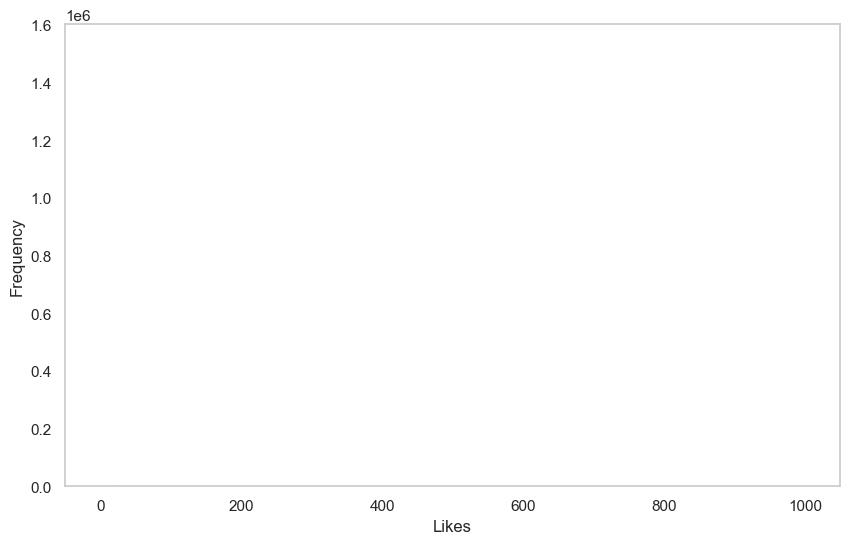

In [317]:
import matplotlib.pyplot as plt

# Plotting the histogram

plt.figure(figsize=(10, 6))
# plt.subplot(1,3)
plt.hist(sentiment_df['like_num'], bins=2000, color='black')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

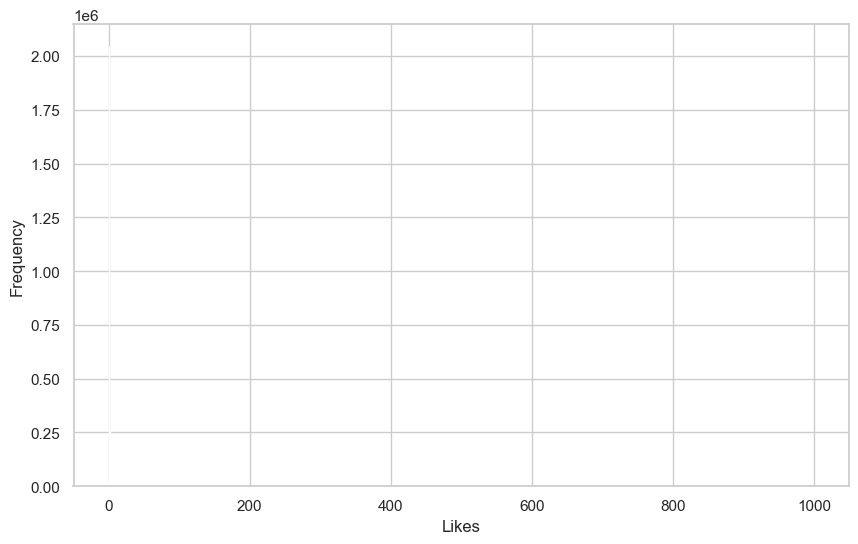

In [273]:
import matplotlib.pyplot as plt

# Plotting the histogram

plt.figure(figsize=(10, 6))
# plt.subplot(1,3)
plt.hist(sentiment_df['retweet_num'], bins=2000, color='black')
plt.xlabel('Likes')
plt.ylabel('Frequency')
#plt.grid(True)
plt.show()

In [274]:
print(sentiment_df['retweet_num'].max())
print(sentiment_df['retweet_num'].min())

print(sentiment_df['like_num'].max())
print(sentiment_df['like_num'].min())

999
0
999
0


In [275]:
# Linear weights
sentiment_df['agreement_weight'] = 1 + 1.5 * sentiment_df['like_num'] + 2 * sentiment_df['retweet_num']
# Log weights to mitigate skweness
sentiment_df['agreement_weight_log'] = 1+ 1.5 * np.log1p(sentiment_df['like_num']) + 2 * np.log1p(sentiment_df['retweet_num'])



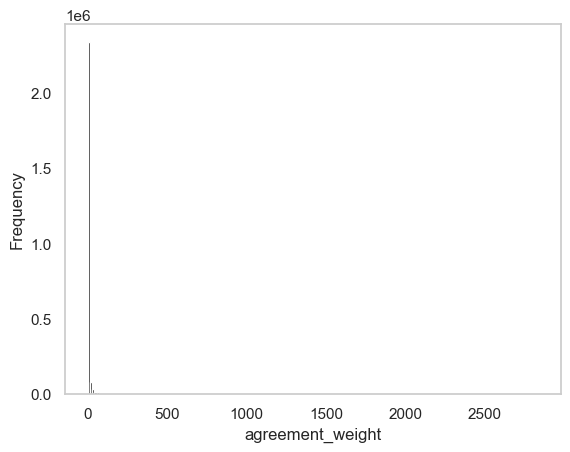

2836.0


In [308]:
plt.hist(sentiment_df['agreement_weight'], bins=200, color='black')
plt.xlabel('agreement_weight')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

print(sentiment_df['agreement_weight'].max())

In [310]:
sentiment_df[sentiment_df['agreement_weight']==2836.0]

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,...,mention_ratio,keyword_count,date_new_york,sentiment,sentiment_probability,sentiment_prob_sum,date_only,date_only_NY,agreement_weight,agreement_weight_log
810550,AAPL,apple,770310550991605760,cnntech,2016-08-29 17:22:01,apples next iphone will likely be unveiled sep...,11,729,918,13,...,0.076923,0,2016-08-29 10:22:01,0,"[0.40977334991477965, 0.4644165876241385, 0.12...",0.283963,2016-08-29,2016-08-29,2836.0,24.421018


In [311]:
sentiment_df['body'][810550]

'apples next iphone will likely be unveiled sept 7 url via @heatherkelly $aapl'

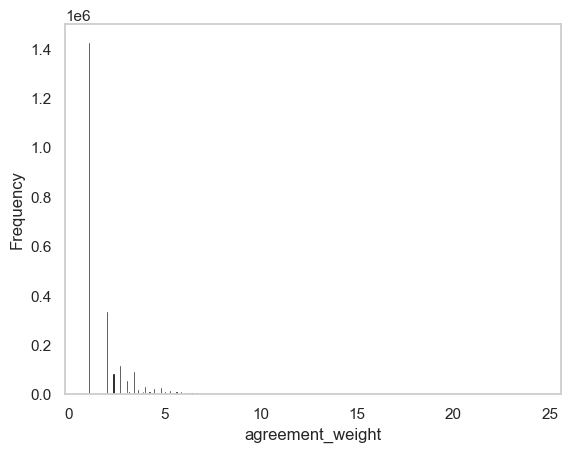

24.421018251818403


In [309]:
plt.hist(sentiment_df['agreement_weight_log'], bins=200, color='black')
plt.xlabel('agreement_weight')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

print(sentiment_df['agreement_weight_log'].max())

In [278]:
sentiment_df.head()

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,...,mention_ratio,keyword_count,date_new_york,sentiment,sentiment_probability,sentiment_prob_sum,date_only,date_only_NY,agreement_weight,agreement_weight_log
0,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling $aapl...,0,0,0,20,...,0.000000,0,2014-12-31 17:01:36,-1,"[0.2874074315094731, 0.23019124368310678, 0.48...",-0.194994,2015-01-01,2014-12-31,1.0,1.000000
1,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla volkswagen pushes 2014 record recall...,0,0,1,13,...,0.153846,0,2014-12-31 17:06:47,1,"[0.6947310550372033, 0.24863109754717022, 0.05...",0.638093,2015-01-01,2014-12-31,2.5,2.039721
2,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with start something n...,0,0,1,12,...,0.083333,1,2014-12-31 17:14:42,0,"[0.408449110584451, 0.42334809219510977, 0.168...",0.240246,2015-01-01,2014-12-31,2.5,2.039721
3,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,@wsj apple is being sued for falsely advertisi...,0,0,0,15,...,0.000000,0,2014-12-31 17:14:42,-1,"[0.29036728717008936, 0.3391678624867592, 0.37...",-0.080098,2015-01-01,2014-12-31,1.0,1.000000
4,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,...,0.000000,0,2014-12-31 17:15:05,1,"[0.5134419420397436, 0.24901102379967055, 0.23...",0.275895,2015-01-01,2014-12-31,1.0,1.000000


In [303]:
sentiment_df.dtypes

ticker_symbol                    object
company_name                     object
tweet_id                          int64
writer                           object
post_date                datetime64[ns]
body                             object
comment_num                       int64
retweet_num                       int64
like_num                          int64
word_count                        int64
hashtag_count                     int64
cashtag_count                     int64
mention_count                     int64
cashtag_ratio                   float64
hashtag_ratio                   float64
mention_ratio                   float64
keyword_count                     int64
date_new_york                    object
sentiment                         int64
sentiment_probability            object
sentiment_prob_sum              float64
date_only                        object
date_only_NY                     object
agreement_weight                float64
agreement_weight_log            float64


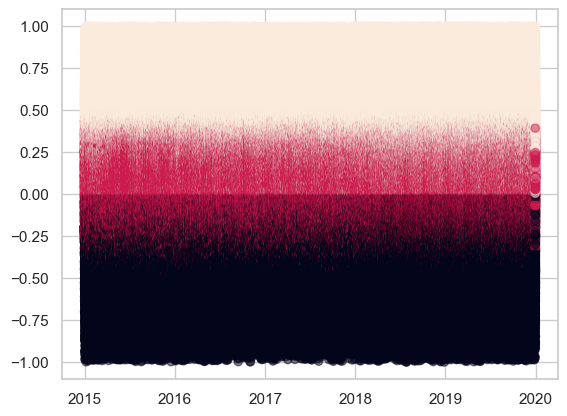

-0.9993054933472284
0.9998051768768412


In [304]:
# Turn labels from int back to categories
sentiment_df['sentiment'] = pd.Categorical(sentiment_df['sentiment'])

plt.scatter(sentiment_df['date_only_NY'], sentiment_df['sentiment_prob_sum'], c=sentiment_df['sentiment'].cat.codes, label=np.unique(sentiment_df['sentiment']), alpha=0.5)
plt.show()

print(sentiment_df['sentiment_prob_sum'].min())
print(sentiment_df['sentiment_prob_sum'].max())

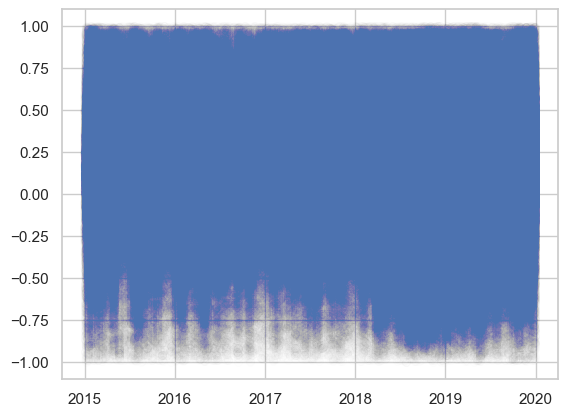

In [307]:
plt.scatter(sentiment_df['date_only_NY'], sentiment_df['sentiment_prob_sum'], alpha=0.005)


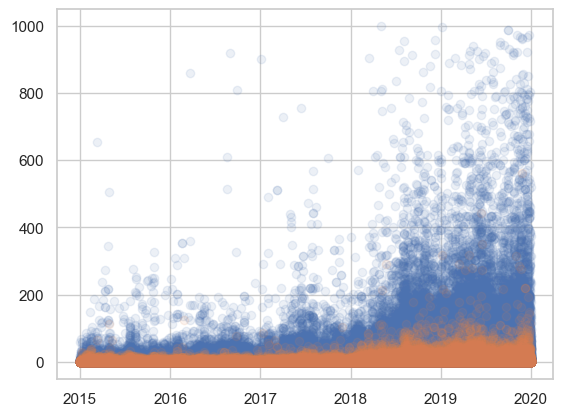

In [323]:
plt.scatter(sentiment_df['date_only_NY'], sentiment_df['like_num'], alpha=0.1)

plt.scatter(sentiment_df['date_only_NY'], sentiment_df['comment_num'], alpha=0.1)

# plt.scatter(sentiment_df['date_only_NY'], sentiment_df['retweet_num'], alpha=0.1)

plt.show()



In [279]:
import pandas as pd

# Example DataFrame
# data = {
#     'company': ['A', 'A', 'B', 'B', 'A'],
#     'date': ['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-02', '2021-01-02'],
#     'tweet': ['Great', 'Bad', 'Great', 'Okay', 'Bad'],
#     'sentiment_score': [0.9, -0.5, 0.8, 0.1, -0.7],
#     'weight': [1.0, 2.0, 1.5, 1.0, 0.5]
# }

# df = pd.DataFrame(data)

# Function to calculate weighted sentiment score
def weighted_sentiment_score(group):
    weighted_scores = group['sentiment_prob_sum'] * group['agreement_weight']
    total_weight = group['agreement_weight'].sum()
    return weighted_scores.sum() / total_weight if total_weight != 0 else 0

# Apply the function after grouping by 'date' and 'company'
weighted_sentiment_df = sentiment_df.groupby(['date_only_NY', 'company_name']).apply(weighted_sentiment_score).reset_index(name='weighted_sentiment_score')



In [280]:
# Function to calculate weighted sentiment score
def weighted_sentiment_score_log(group):
    weighted_scores = group['sentiment_prob_sum'] * group['agreement_weight_log']
    total_weight = group['agreement_weight_log'].sum()
    return weighted_scores.sum() / total_weight if total_weight != 0 else 0

# Apply the function after grouping by 'date' and 'company'
log_weighted_sentiment_df = sentiment_df.groupby(['date_only_NY', 'company_name']).apply(weighted_sentiment_score_log).reset_index(name='weighted_sentiment_score')



In [281]:
log_weighted_sentiment_df.head(n=10)

,date_only_NY,company_name,weighted_sentiment_score
0,2014-12-31,Amazon.com,-0.073298
1,2014-12-31,Google Inc,0.254385
2,2014-12-31,Microsoft,0.224798
3,2014-12-31,Tesla Inc,0.485993
4,2014-12-31,apple,0.146709
5,2015-01-01,Amazon.com,0.147703
6,2015-01-01,Google Inc,0.141722
7,2015-01-01,Microsoft,0.154805
8,2015-01-01,Tesla Inc,0.063733
9,2015-01-01,apple,0.159862


In [282]:
weighted_sentiment_df.head(n=10)

,date_only_NY,company_name,weighted_sentiment_score
0,2014-12-31,Amazon.com,-0.074386
1,2014-12-31,Google Inc,0.268702
2,2014-12-31,Microsoft,0.218625
3,2014-12-31,Tesla Inc,0.481978
4,2014-12-31,apple,0.014200
5,2015-01-01,Amazon.com,0.153457
6,2015-01-01,Google Inc,0.141055
7,2015-01-01,Microsoft,0.147046
8,2015-01-01,Tesla Inc,0.030527
9,2015-01-01,apple,0.161043


In [324]:
unweighted_sentiment_df = sentiment_df.groupby(['date_only_NY', 'company_name'])['sentiment_prob_sum'].mean().reset_index()
unweighted_sentiment_df.columns = ['date_NY', 'company_name', 'unweighted_sentiment_score']

In [283]:
unweighted_sentiment_df.head()

,date_NY,company_name,unweighted_sentiment_score
0,2014-12-31,Amazon.com,-0.072244
1,2014-12-31,Google Inc,0.217031
2,2014-12-31,Microsoft,0.205846
3,2014-12-31,Tesla Inc,0.499599
4,2014-12-31,apple,0.203056


Load market cap data

In [284]:
# Load market cap file
# Are 

market_cap_path = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/market_cap/total_market_cap_2015-2019.xlsx"

market_cap_df = pd.read_excel(market_cap_path).sort_values("date")

market_cap_df['date'] = pd.to_datetime(market_cap_df['date'])

market_cap_df['weights_abs'] = market_cap_df['weights_abs'].astype(int)

market_cap_df['weights_rel'] = market_cap_df.groupby('date')['weights_abs'].transform(lambda x: x / x.sum())

# replace company ticker by company name for a smooth join

replacements = {"AAPL.O": "apple", "AMZN.O": "Amazon.com", "GOOG.O": "Google Inc", "MSFT.O": "Microsoft", "TSLA.O": "Tesla Inc"}

market_cap_df['company_ticker'] = market_cap_df['company_ticker'].replace(replacements)

market_cap_df.rename(columns={'company_ticker': 'company_name'}, inplace=True)



In [285]:
market_cap_df.head()

,company_name,date,weekday,market_cap,weights_abs,weights_rel
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972
5032,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592
2516,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381
3774,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977
1258,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078


In [286]:
market_cap_df.dtypes

company_name            object
date            datetime64[ns]
weekday                  int64
market_cap             float64
weights_abs              int64
weights_rel            float64
dtype: object

In [287]:
log_weighted_sentiment_df.dtypes

date_only_NY                 object
company_name                 object
weighted_sentiment_score    float64
dtype: object

In [288]:
# before joining, adapt column names of log_weighted_sentiment_df
log_weighted_sentiment_df.rename(columns={'date_only_NY': 'date'}, inplace=True)
log_weighted_sentiment_df['date'] = pd.to_datetime(log_weighted_sentiment_df['date'])

# join market_cap_df and log_weighted_sentiment_df
sentiment_market_cap_df = pd.merge(market_cap_df, log_weighted_sentiment_df, on=['date', 'company_name'])

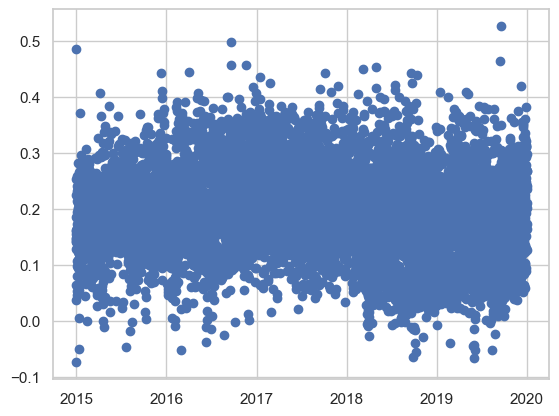

In [289]:
plt.scatter(log_weighted_sentiment_df['date'], log_weighted_sentiment_df['weighted_sentiment_score'])

In [290]:
sentiment_market_cap_df.head(n=10)

,company_name,date,weekday,market_cap,weights_abs,weights_rel,weighted_sentiment_score
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972,0.143463
1,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592,0.038038
2,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381,0.127902
3,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977,0.185871
4,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078,0.161868
5,Google Inc,2015-01-05,0,3.504869e+11,370020000000,0.224381,0.155350
6,Amazon.com,2015-01-05,0,1.405184e+11,156790000000,0.095078,0.140510
7,Tesla Inc,2015-01-05,0,2.634146e+10,30660000000,0.018592,0.128544
8,apple,2015-01-05,0,6.231392e+11,697510000000,0.422972,0.172829
9,Microsoft,2015-01-05,0,3.818502e+11,394090000000,0.238977,0.258740


In [291]:
# test
# 0.422972*0.143463+0.018592*0.038038+0.224381*0.127902+0.238977*0.185871+0.095078*0.161868

In [328]:
# before joining, adapt column names of unweighted_sentiment_df
unweighted_sentiment_df.rename(columns={'date_NY': 'date'}, inplace=True)
unweighted_sentiment_df['date'] = pd.to_datetime(unweighted_sentiment_df['date'])

# join market_cap_df and unweighted_sentiment_df
unweighted_sentiment_market_cap_df = pd.merge(market_cap_df, unweighted_sentiment_df, on=['date', 'company_name'])

In [329]:
unweighted_sentiment_market_cap_df

,company_name,date,weekday,market_cap,weights_abs,weights_rel,unweighted_sentiment_score
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972,0.140974
1,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592,0.046649
2,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381,0.138962
3,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977,0.191176
4,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078,0.165186
...,...,...,...,...,...,...,...
6285,Microsoft,2019-12-31,1,1.203063e+12,1154848594452,0.275336,0.255165
6286,Amazon.com,2019-12-31,1,9.161539e+11,892831633776,0.212867,0.241794
6287,apple,2019-12-31,1,1.304765e+12,1187462571250,0.283112,0.239024
6288,Google Inc,2019-12-31,1,9.229463e+11,899713394424,0.214507,0.189541


In [330]:
# Calculate the weighted average of sentiment per day
sentiment_index_unweighted_df = unweighted_sentiment_market_cap_df.groupby('date').apply(
    lambda x: pd.Series({
        'sentiment_score': (x['weights_rel'] * x['unweighted_sentiment_score']).sum()
    })
).reset_index()

In [331]:
sentiment_index_unweighted_df.head()

,date,sentiment_score
0,2015-01-02,0.153068
1,2015-01-05,0.179887
2,2015-01-06,0.170999
3,2015-01-07,0.186507
4,2015-01-08,0.216370


In [292]:
# Calculate the weighted average of sentiment per day
sentiment_index_log_df = sentiment_market_cap_df.groupby('date').apply(
    lambda x: pd.Series({
        'sentiment_score': (x['weights_rel'] * x['weighted_sentiment_score']).sum()
    })
).reset_index()

In [293]:
sentiment_index_log_df.head()

,date,sentiment_score
0,2015-01-02,0.149896
1,2015-01-05,0.185542
2,2015-01-06,0.165909
3,2015-01-07,0.182038
4,2015-01-08,0.226006


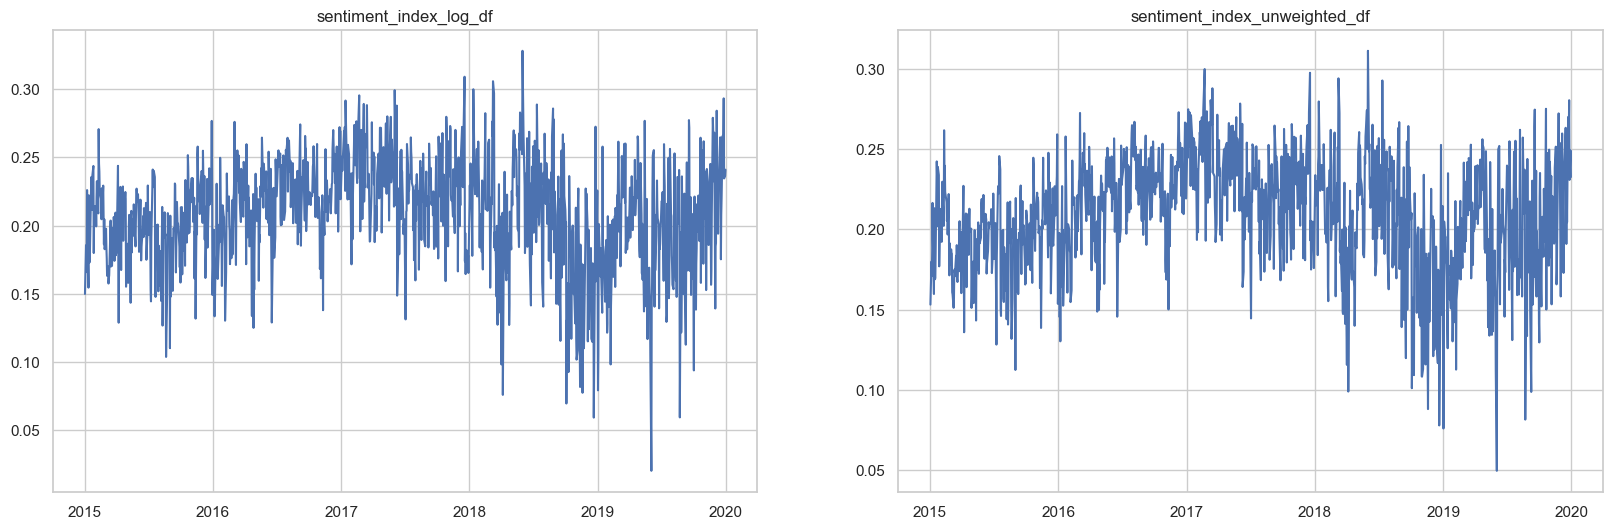

In [337]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(sentiment_index_log_df['date'],sentiment_index_log_df['sentiment_score'])
plt.title('sentiment_index_log_df')
plt.subplot(1, 2, 2)
plt.plot(sentiment_index_unweighted_df['date'],sentiment_index_unweighted_df['sentiment_score'])
plt.title('sentiment_index_unweighted_df')
plt.show()

As this score is weighted with market cap data, it only includes weekdays. Should this be changed to also included weekends?

In [340]:
# Save unweighted index
sentiment_index_unweighted_path = "Users/friederikeeichholz/Library/CloudStorage/OneDrive-LundUniversity/Desktop/DABN01_Thesis/index/sentiment_index_unweighted.xlsx"

sentiment_index_unweighted_df.to_excel(sentiment_index_unweighted_path, index=False)

# Save log weighted index
sentiment_index_log_path = "Users/friederikeeichholz/Library/CloudStorage/OneDrive-LundUniversity/Desktop/DABN01_Thesis/index/sentiment_index_log_weighted.xlsx"

sentiment_index_log_df.to_excel(sentiment_index_log_path, index=False)

